In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch 
import torch.nn as nn

import numpy as np
from time import time
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

from PIL import Image
from resources.MODNet.src.models.modnet import MODNet
from resources.MODNet.inference.image_matting.inference_class import InfernceIMG

pretrained_ckpt = '../../resources/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'

#/home/dev/work_main/courses/Efficient-DL-Models/

# model: https://github.com/ZHKKKe/MODNet/tree/master

os.path.isfile(pretrained_ckpt)

True

In [3]:
weights = torch.load(pretrained_ckpt,  map_location=torch.device('cpu'))

model = MODNet(backbone_pretrained=False)
model.load_state_dict(weights)


<All keys matched successfully>

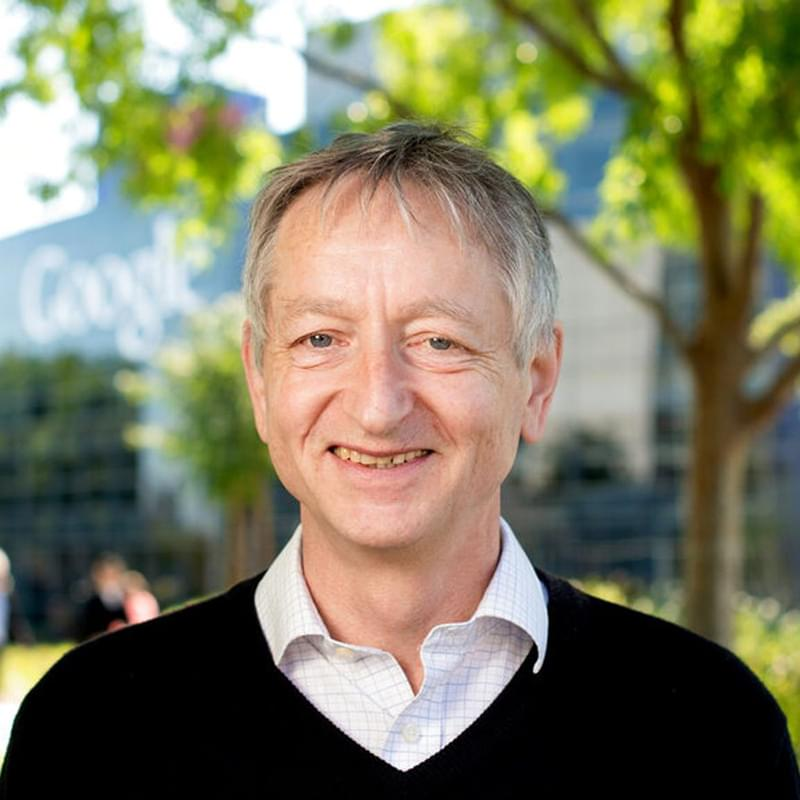

In [4]:
original_image = Image.open('data/input/hinton.jpg')
original_image

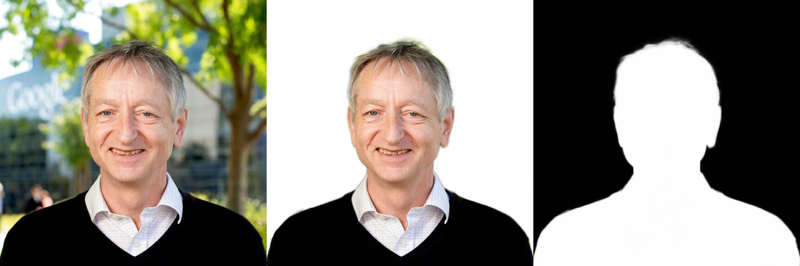

In [5]:
inferer = InfernceIMG(device='cpu')

matte =  inferer.transform(model, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined

In [6]:
def test_time(model, n=100, batch_size=1):

    time_total = np.zeros(shape=n)
    # run inference
    batch = torch.rand(batch_size,3,512,512)
    for i in range(n):
        start = time()
        with torch.no_grad():
            output = model(batch, True)
        end = time()
        time_total[i] = end - start
        
    print(f'execution time for model is: {time_total.mean():.4f} +/- {time_total.std():.4f}')

In [7]:
test_time(model, n=100)

execution time for model is: 0.3432 +/- 0.0327


In [9]:
class Qmodel(nn.Module):
    def __init__(self, base, q = False):
        # By turning on Q we can turn on/off the quantization
        super(Qmodel, self).__init__()
        self.q = q
        self.base = base
        if q:
          self.quant = QuantStub()
          self.dequant = DeQuantStub()

    def forward(self, x: torch.Tensor, inference) -> torch.Tensor:
        if self.q:
          x = self.quant(x)
          
          o1, o2, matte = self.base(x, inference)
        
        if self.q:
          matte = self.dequant(matte)
        return o1,o2, matte

In [10]:
from torch.ao.quantization import get_default_qconfig_mapping
from torch.ao.quantization import QConfigMapping
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.quantization.observer import MovingAverageMinMaxObserver

base = MODNet(backbone_pretrained=False)
base.load_state_dict(weights)

qmodel = Qmodel(base, q=True)
qmodel.eval()


qmodel.qconfig =  torch.ao.quantization.get_default_qconfig('fbgemm')

prepared_model = torch.ao.quantization.prepare(qmodel, inplace=False)

/home/diff7/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [11]:
matte =  inferer.transform(prepared_model, original_image)

prepared_model

Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(
              3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
              (activation_post_process): HistogramObserver(min_val=-10.067789077758789, max_val=8.715587615966797)
            )
            (1): BatchNorm2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (activation_post_process): HistogramObserver(min_val=-2.0354180335998535, max_val=3.3608617782592773)
            )
            (2): ReLU6(
              inplace=True
              (activation_post_process): HistogramObserver(min_val=0.0, max_val=3.3608617782592773)
            )
          )
          (1): InvertedResidual(
            (ff): FloatFunctional(
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
            )
            (conv): Sequent

In [36]:
qmodel_int8 = torch.ao.quantization.convert(prepared_model)
print(qmodel_int8)

Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.14598619937896729, zero_point=67, padding=(1, 1), bias=False)
            (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): QuantizedReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (ff): QFunctional(
              scale=1.0, zero_point=0
              (activation_post_process): Identity()
            )
            (conv): Sequential(
              (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.09006185084581375, zero_point=65, padding=(1, 1), groups=32, bias=False)
              (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): QuantizedReLU6(inplace=True)
              (3): Quantiz

In [12]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(model, n=100, batch_size=1)
        
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2024-11-11 21:33:07 391019:391019 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


execution time for model is: 0.4024 +/- 0.0492


STAGE:2024-11-11 21:33:48 391019:391019 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-11-11 21:33:48 391019:391019 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        55.32%       22.282s        55.57%       22.383s       3.244ms          6900  
         aten::native_batch_norm        18.11%        7.293s        18.31%        7.373s     877.763us          8400  
       aten::upsample_bilinear2d         9.25%        3.724s        10.21%        4.114s       4.541ms           906  
                       aten::cat         6.62%        2.667s         6.69%        2.694s       1.225ms          2200  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 40.278s



In [13]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(qmodel_int8, n=100, batch_size=1)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2024-11-11 21:34:11 391019:391019 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-11-11 21:34:11 391019:391019 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-11-11 21:34:11 391019:391019 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


NameError: name 'qmodel_int8' is not defined

In [ ]:
compiled = torch.compile(qmodel_int8)

In [ ]:
test_time(compiled, n=100, batch_size=1)

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(compiled, n=100, batch_size=4)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

In [ ]:
torch.save(qmodel_int8.state_dict(), 'MODNet/pretrained/q_model.ckpt')

In [ ]:
matte =  inferer.transform(compiled, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined